# Transformers for Vision

## Understanding Transformers through implementation and visualization of attention weights by dissecting the model intermediate layers

Transformers have been shown to be a great neural network architecture and works well in various domains, particularly proving itself in the field of NLP and Vision. This is an encoder-decoder architecture, with encoder block generating keys, and values for the decoder block through multi-headed self-attention, and the decoder block generating queries through a masked multi-headed self-attention block. The key-value pair from encoder and query from decoder is then passed through another multi-headed self-attention (effectively cross-attention) to generate output probability vectors.

![](media/transformer.png)

The attention mechanism is given by the equation: $Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d}})V$, where $\sqrt{d}$ is the scale used to normalize the `dot-product` to stabilize back-propagation through `softmax` function even for extremely large magnitude of `dot-product`. `d` in the equation is the dimension of `query` and `keys`. This is also known as the `Scaled Dot-Product Attention`. 
In a `Multi-Head Attention`, we simply project the input through `h` attention blocks instead of just one. This allows the network to learn `h` different attention functions where each of them could focus on a specific property of the data. This is described by the equation: $MultiHead(Q, K, V) = Concat(head_1, \cdots, head_h)W^O$, where, $head_i = Attention(QW^Q_i , KW^K_i , VW^V_i)$.
Optionally, these multi-headed attention could take in a mask useful for masking future elements in the sequence to disallow network from cheating in tasks such as $\textit{next-word prediction}$. We set the elements to be masked to be very small, e.g. $-\infty$, which results in a value close to 0 after the softmax operation.

Now that we know what a Multi-Head Attention is, let's try to implement this in pytorch

In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, hidden_size: int, 
                       n_heads: int=8):
        super(MultiHeadedAttention, self).__init__()
        assert hidden_size % n_heads == 0
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.wq = nn.Linear(self.hidden_size, self.hidden_size)
        self.wk = nn.Linear(self.hidden_size, self.hidden_size)
        self.wv = nn.Linear(self.hidden_size, self.hidden_size)
        self.out_linear = nn.Linear(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.scale = self.hidden_size ** 0.5
            
    def forward(self, q: torch.Tensor, 
                      k: torch.Tensor, 
                      v: torch.Tensor,
                      mask=None):
        """
        Args:
            q: (B, N, D) (batch size x sequence length x hidden size) query
            k: (B, N, D) (batch size x sequence length x hidden size) key
            v: (B, N, D) (batch size x sequence length x hidden size) value
            mask: (B, N) (batch size x sequence length) mask if needed
        """
        assert q.shape == k.shape
        assert q.shape == v.shape
        B, N, D = q.shape
        assert D == self.hidden_size, "hidden size mismatched"
        # apply linear layers
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        # split into multiple heads and convert to (B, n_heads, N, D/n_heads)
        q = q.view(B, N, self.n_heads, D // self.n_heads).transpose(1, 2)
        k = k.view(B, N, self.n_heads, D // self.n_heads).transpose(1, 2)
        v = v.view(B, N, self.n_heads, D // self.n_heads).transpose(1, 2)
        # compute attention scores
        attention_score = q @ k.transpose(-1, -2) / self.scale
        # apply mask if needed
        if mask is not None:
            attention_score.masked_fill(mask, -1e10)
        # turn them into probabilities
        attention_weights = F.softmax(attention_score, dim=-1)
        attention_weights = self.dropout(attention_weights)
        # compute context vector as weighed values with computed attention probabilities
        context = attention_weights @ v
        # convert back to (B, N, n_heads, D/n_heads)
        context = context.transpose(1, 2)
        # merge all heads
        context = context.contiguous().view(B, N, D)
        # apply output prjection layer 
        out = self.out_linear(context)
        
        return out, attention_weights

Now let's zoom out a little bit to focus on the encoder part of Transformers. This includes two additional blocks - `Add & Norm`, and `Feed Forward`. `Add & Norm` provides a residual connection followed by a layer normalization, while the `Feed Forward` is a simple, position-wise fully connected feed-forward network.

In [3]:
class TransformersEncoderBlock(nn.Module):
    def __init__(self, hidden_size: int, 
                       n_heads: int=8,
                       device=torch.device('cuda')):
        super(TransformersEncoderBlock, self).__init__()
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        self.attention = MultiHeadedAttention(
                            hidden_size=hidden_size,
                            n_heads=n_heads).to(device)
        self.norm = nn.LayerNorm(hidden_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(0.1))
        
    def forward(self, x: torch.Tensor):
        # multi-headed attention
        x_att, att_weights = self.attention(x, x, x)
        # add and norm
        x_att = self.norm(x + x_att)
        # feed-forward
        x_ff = self.feed_forward(x_att)
        # add and norm
        x_out = self.norm(x_att + x_ff)
        
        return x_out, att_weights
    
class TransformersEncoder(nn.Module):
    def __init__(self, hidden_size: int, 
                       n_heads: int=8, 
                       n_encoders: int=6,
                       device=torch.device('cuda')):
        super(TransformersEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        self.n_encoders = n_encoders
        self.encoders = nn.Sequential(*[TransformersEncoderBlock(
                                        hidden_size=hidden_size, 
                                        n_heads=n_heads,
                                        device=device) for _ in range(n_encoders)])
        
    def forward(self, x: torch.Tensor):
        
        att_weights_list = []
        for encoder in self.encoders:
            x, att_weights = encoder(x)
            att_weights_list.append(att_weights)
        
        return x, att_weights_list

With encoder out of the way, let's now look into the decoder implementation, which is very similar to the encoder except for an additional `Masked Multi-Headed Self-Attention`, output of which serves as the `value` vector for next `Multi-Headed Self-Attention` while the `query` and `key` vectors come from the encoder output.

In [4]:
class TransformersDecoderBlock(nn.Module):
    def __init__(self, hidden_size: int, 
                       n_heads: int=8,
                       device=torch.device('cuda')):
        super(TransformersDecoderBlock, self).__init__()
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        self.attention = MultiHeadedAttention(
                            hidden_size=hidden_size, 
                            n_heads=n_heads).to(device)
        self.norm = nn.LayerNorm(hidden_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(0.1))
        
    def forward(self, x: torch.Tensor, 
                      enc_out: torch.Tensor,
                      mask=None):
        
        # masked multi-headed self-attention
        x_masked_att, self_att_weights = self.attention(x, x, x, mask=mask)
        # add and norm
        x_masked_att = self.norm(x + x_masked_att)
        # multi-headed cross-attention
        x_att, cross_att_weights = self.attention(x_masked_att, enc_out, enc_out)
        # add and norm
        # Note that I have made a minor change here - In original Transformers architecture
        # we would add 'x_masked_att' and 'x_att' for the residual connection, but here I
        # am adding 'enc_out' and 'x_att' together instead
        x_att = self.norm(enc_out + x_att)
        # feed-forward
        x_ff = self.feed_forward(x_att)
        # add and norm
        x_out = self.norm(x_att + x_ff)
        
        return x_out, self_att_weights, cross_att_weights
    
class TransformersDecoder(nn.Module):
    def __init__(self, hidden_size: int, 
                       n_heads: int=8,
                       n_decoders: int=6,
                       device=torch.device('cuda')):
        super(TransformersDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        self.n_decoders = n_decoders
        self.decoders = nn.Sequential(*[TransformersDecoderBlock(
                                        hidden_size=hidden_size,
                                        n_heads=n_heads,
                                        device=device) for _ in range(n_decoders)])
        
    def forward(self, x: torch.Tensor,
                      enc_out: torch.Tensor,
                      mask=None):
        # pass through all decoder blocks
        self_att_weights_list = []
        cross_att_weights_list = []
        for decoder in self.decoders:
            x, self_att_weights, cross_att_weights = decoder(x, enc_out, mask)
            self_att_weights_list.append(self_att_weights)
            cross_att_weights_list.append(cross_att_weights)
            
        return x, self_att_weights_list, cross_att_weights_list

We have so far defined Transformers encoder and decoder. As the next step, we need to combine them into a complete Transformers architecture. Another concept that is important to understand is `Positional Embedding`, which is normally added to the input vector to understand the ordering of input sequences since Transformers are position invariant. Usual choice for this positional encoding is to use a combination of sine and cosine functions, but one can also use learnable positional encoding, which is what we will use in our example.
The application kept in mind here is to classify MNIST digits, in which case the sequence length is always going to be the same, and we do not need to mask decoder input - we can instead learn them. In natural language processing, you also learn an embedding for each sub-word through the `Input Embedding` layer, which projects a one-hot vector to a lower-dimensional word vector. We can replace this with a linear layer so that it projects each pixel value to a higher dimensional vector.

In [5]:
class Config(object):
    sequence_len = 28*28
    hidden_size = 512
    n_heads = 8
    n_encoders = 6
    n_decoders = 6
    n_queries = 10
    n_classes = 10
    dropout = 0.1
    encoder_only=False
    device = torch.device('cuda')
    
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
                
class Transformers(nn.Module):
    def __init__(self, config: Config):
        super(Transformers, self).__init__()
        
        # input embedding layer
        self.inp_embedding = nn.Linear(1, config.hidden_size)
        
        # learnable queries
        self.queries = nn.Parameter(torch.zeros(1, config.n_queries, config.sequence_len))
        nn.init.normal_(self.queries)
        
        # query embedding layer
        self.query_embedding = nn.Linear(config.n_queries, config.hidden_size)
        
        # encoder positional embedding
        self.enc_pos_emb = nn.Parameter(torch.zeros(1, config.sequence_len, config.hidden_size))
        self.dec_pos_emb = nn.Parameter(torch.zeros(1, config.sequence_len, config.hidden_size))
        
        # encoder
        self.encoder = TransformersEncoder(hidden_size=config.hidden_size,
                                            n_heads=config.n_heads,
                                            n_encoders=config.n_encoders,
                                            device=config.device)
        
        # decoder
        self.decoder = TransformersDecoder(hidden_size=config.hidden_size,
                                            n_heads=config.n_heads,
                                            n_decoders=config.n_decoders,
                                            device=config.device)
        
        # output linear layer for classification
        self.out_linear = nn.Linear(config.sequence_len * config.hidden_size, 
                                    config.n_classes)
        
    def forward(self, x: torch.Tensor,
                      encoder_only: bool=False,
                      return_attention_weights: bool=False,
                      return_queries: bool=False):
        B, C, H, W = x.shape
        ## encoder
        x = x.view(B, C*H*W, 1)
        # embedding
        x_enc = self.inp_embedding(x)
        # add positional embeddings to input
        x_enc = x_enc + self.enc_pos_emb
        # pass through the encoder
        x_enc, self_att_enc = self.encoder(x_enc)
        
        ## decoder
        x_query = self.queries.transpose(-1, -2).repeat(x.shape[0], 1, 1)
        # embedding
        x_dec = self.query_embedding(x_query)
        # add positional embeddings
        x_dec = x_dec + self.dec_pos_emb
        # pass through the encoder
        x_dec, self_att_dec, cross_att_dec = self.decoder(x_dec, x_enc)
        
        ## classification
        if encoder_only:
            y = F.softmax(self.out_linear(x_enc.view(B, -1)), dim=-1)
        else:
            y = F.softmax(self.out_linear(x_dec.view(B, -1)), dim=-1)
        
        metadata = {}
        if return_attention_weights:
            metadata = {'self_att_enc':self_att_enc,
                        'self_att_dec':self_att_dec,
                        'cross_att_dec':cross_att_dec}
        if return_queries:
            metadata['query'] = self.queries.view(config.n_queries, H, W)
            
        return y, metadata

Original transformers introduced by Vaswani et al. int the paper "Attention Is All You Need" (https://arxiv.org/abs/1706.03762), contains an `encoder-decoder` architecture. Several workstreams however explores an `encoder-only` or a `decoder-only` architecture which performs better on specific tasks while costs less memory and time for training. An example of encoder-only architecture is BERT where certain tokens are masked in the input and the network is tasked to predict those missing tokens. Similarly, GPT-n is an example of decoder-only architecture, where, given past $\textit{n}$ tokens, the network is trained to predict $\textit{(n+1)}^{th}$ token.
For a simple image classification example in consideration here, an encoder-only architecture will work pretty well, however, here I build an `encoder-decoder` architecture, as well as add support for `encoder-only` architecture for complete understanding of how to build and train such a system. I train both networks in this notebook and visualize attention layers.

Let's define the MNIST dataset and dataloader classes

In [6]:
# define parameters
dataroot = './data'
batch_size = 20
learning_rate = 0.0001
momentum=0.9
n_epochs = 2

transform=torchvision.transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Normalize(
                                         (0.1307,), (0.3081,))
                                        ])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
trainset = torchvision.datasets.MNIST(root=dataroot, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root=dataroot, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [8]:
class ClassificationAccuracy(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        # the class with the highest energy is what we choose as prediction
        total = y_true.size(0)
        _, pred = y_pred.max(dim=1)
        correct = (pred == y_true).sum()
        acc = correct / total
        
        # return metrics
        return acc

## Train model and perform evaluation on validation set

In [9]:
import time
from tqdm.notebook import tqdm
import torch.optim as optim
    
# train function
def train(model):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    print_every = 100

    # start training
    start_time = time.time()
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_acc = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs, metadata = model(inputs, encoder_only=config.encoder_only)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_acc += ClassificationAccuracy()(outputs, labels).item()
            if i % print_every == (print_every-1):    # print every 2000 mini-batches
                print(f'\repoch [{epoch + 1}], step [{i + 1:5d}] loss: {running_loss / print_every:.8f} acc: {running_acc / print_every:.8f}', end='')
                running_loss = 0.0
                running_acc = 0.0

        print()
    end_time = time.time()
    print(f'Training took {end_time - start_time} seconds.')

    # perform validation
    print('Performing validation')
    model.eval()
    running_acc = 0.0
    for i, (inputs, labels) in tqdm(enumerate(testloader, 0), total=len(testloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs, metadata = model(inputs, 
                                  encoder_only=config.encoder_only,
                                  return_attention_weights=False, 
                                  return_queries=False)

        # print statistics
        running_acc += ClassificationAccuracy()(outputs, labels).item()

    avg_acc = running_acc / len(testloader)
    print(f'Validation accuracy: {avg_acc}')
    
    return model

## Functions to visualize attention layers

In [10]:
import matplotlib.pyplot as plt

def visualize_attention(attention_weights):
    n_layers = len(attention_weights)
    B, n_heads, m, n = attention_weights[0].shape
    
    fig, axes = plt.subplots(n_layers, n_heads)
    fig.set_size_inches(18.5*2, 10.5*2)
    for layer in range(n_layers):
        for i in range(n_heads):
            att = attention_weights[layer].detach().cpu().numpy()[0, i]
            # these layers show how much each pixel (row) pays attention to
            # every other pixels in the image. Let's visualize what the center
            # pixel pays attention to
            center_pix_idx = att.shape[0] // 2
            att_row = att[center_pix_idx, :].reshape(28,28)
            
            axes[layer, i].imshow(att_row)
            axes[layer, i].set(xlabel=f"head={i}")
            if i == 0:
                axes[layer, i].set(ylabel=f"layer={layer}")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    
def visualize_queries(queries):
    n_queries, h, w = queries.shape
    
    plt.figure(figsize=(4*n_queries, 4))
    for i in range(n_queries):
        query = queries[i].detach().cpu().numpy()
        plt.subplot(1,n_queries,i+1)
        plt.imshow(query)
        plt.axis('off')
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [11]:
def visualize_model_layers(model, testloader):
    inputs, labels = next(iter(testloader))
    inputs = inputs.to(device)
    labels = labels.to(device)

    model.eval()
    outputs, metadata = model(inputs, 
                              encoder_only=config.encoder_only,
                              return_attention_weights=True, 
                              return_queries=True)

    _, pred = outputs.max(dim=1)
    print(f'Prediction: {pred.detach().cpu().numpy()[0]}, True: {labels.detach().cpu().numpy()[0]}')
    plt.imshow(inputs.detach().cpu().numpy()[0].squeeze(0))
    plt.axis('off')
    plt.show()

    print('Transformers Encoder Self-Attention')
    visualize_attention(metadata['self_att_enc'])

    if not config.encoder_only:
        print('Transformers Decoder Self-Attention')
        visualize_attention(metadata['self_att_dec'])

        print('Transformers Decoder Cross-Attention')
        visualize_attention(metadata['cross_att_dec'])

        print('Learnt Query Vectors')
        visualize_queries(metadata['query'])

## Train and visualize encoder-decoder model

In [12]:
config = Config(device=device, 
                hidden_size=128, 
                n_heads=8, 
                n_encoders=4, 
                n_decoders=4,
                n_queries=1,
                encoder_only=False)

model = Transformers(config).to(device)
model = train(model)

epoch [1], step [ 3000] loss: 1.57930688 acc: 0.89300001
epoch [2], step [ 3000] loss: 1.55892931 acc: 0.91050001
Training took 1048.3066067695618 seconds.
Performing validation


  0%|          | 0/500 [00:00<?, ?it/s]

Validation accuracy: 0.9217000086307525


Prediction: 7, True: 7


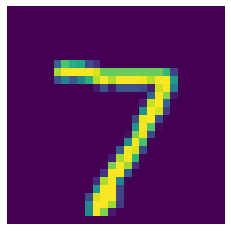

Transformers Encoder Self-Attention


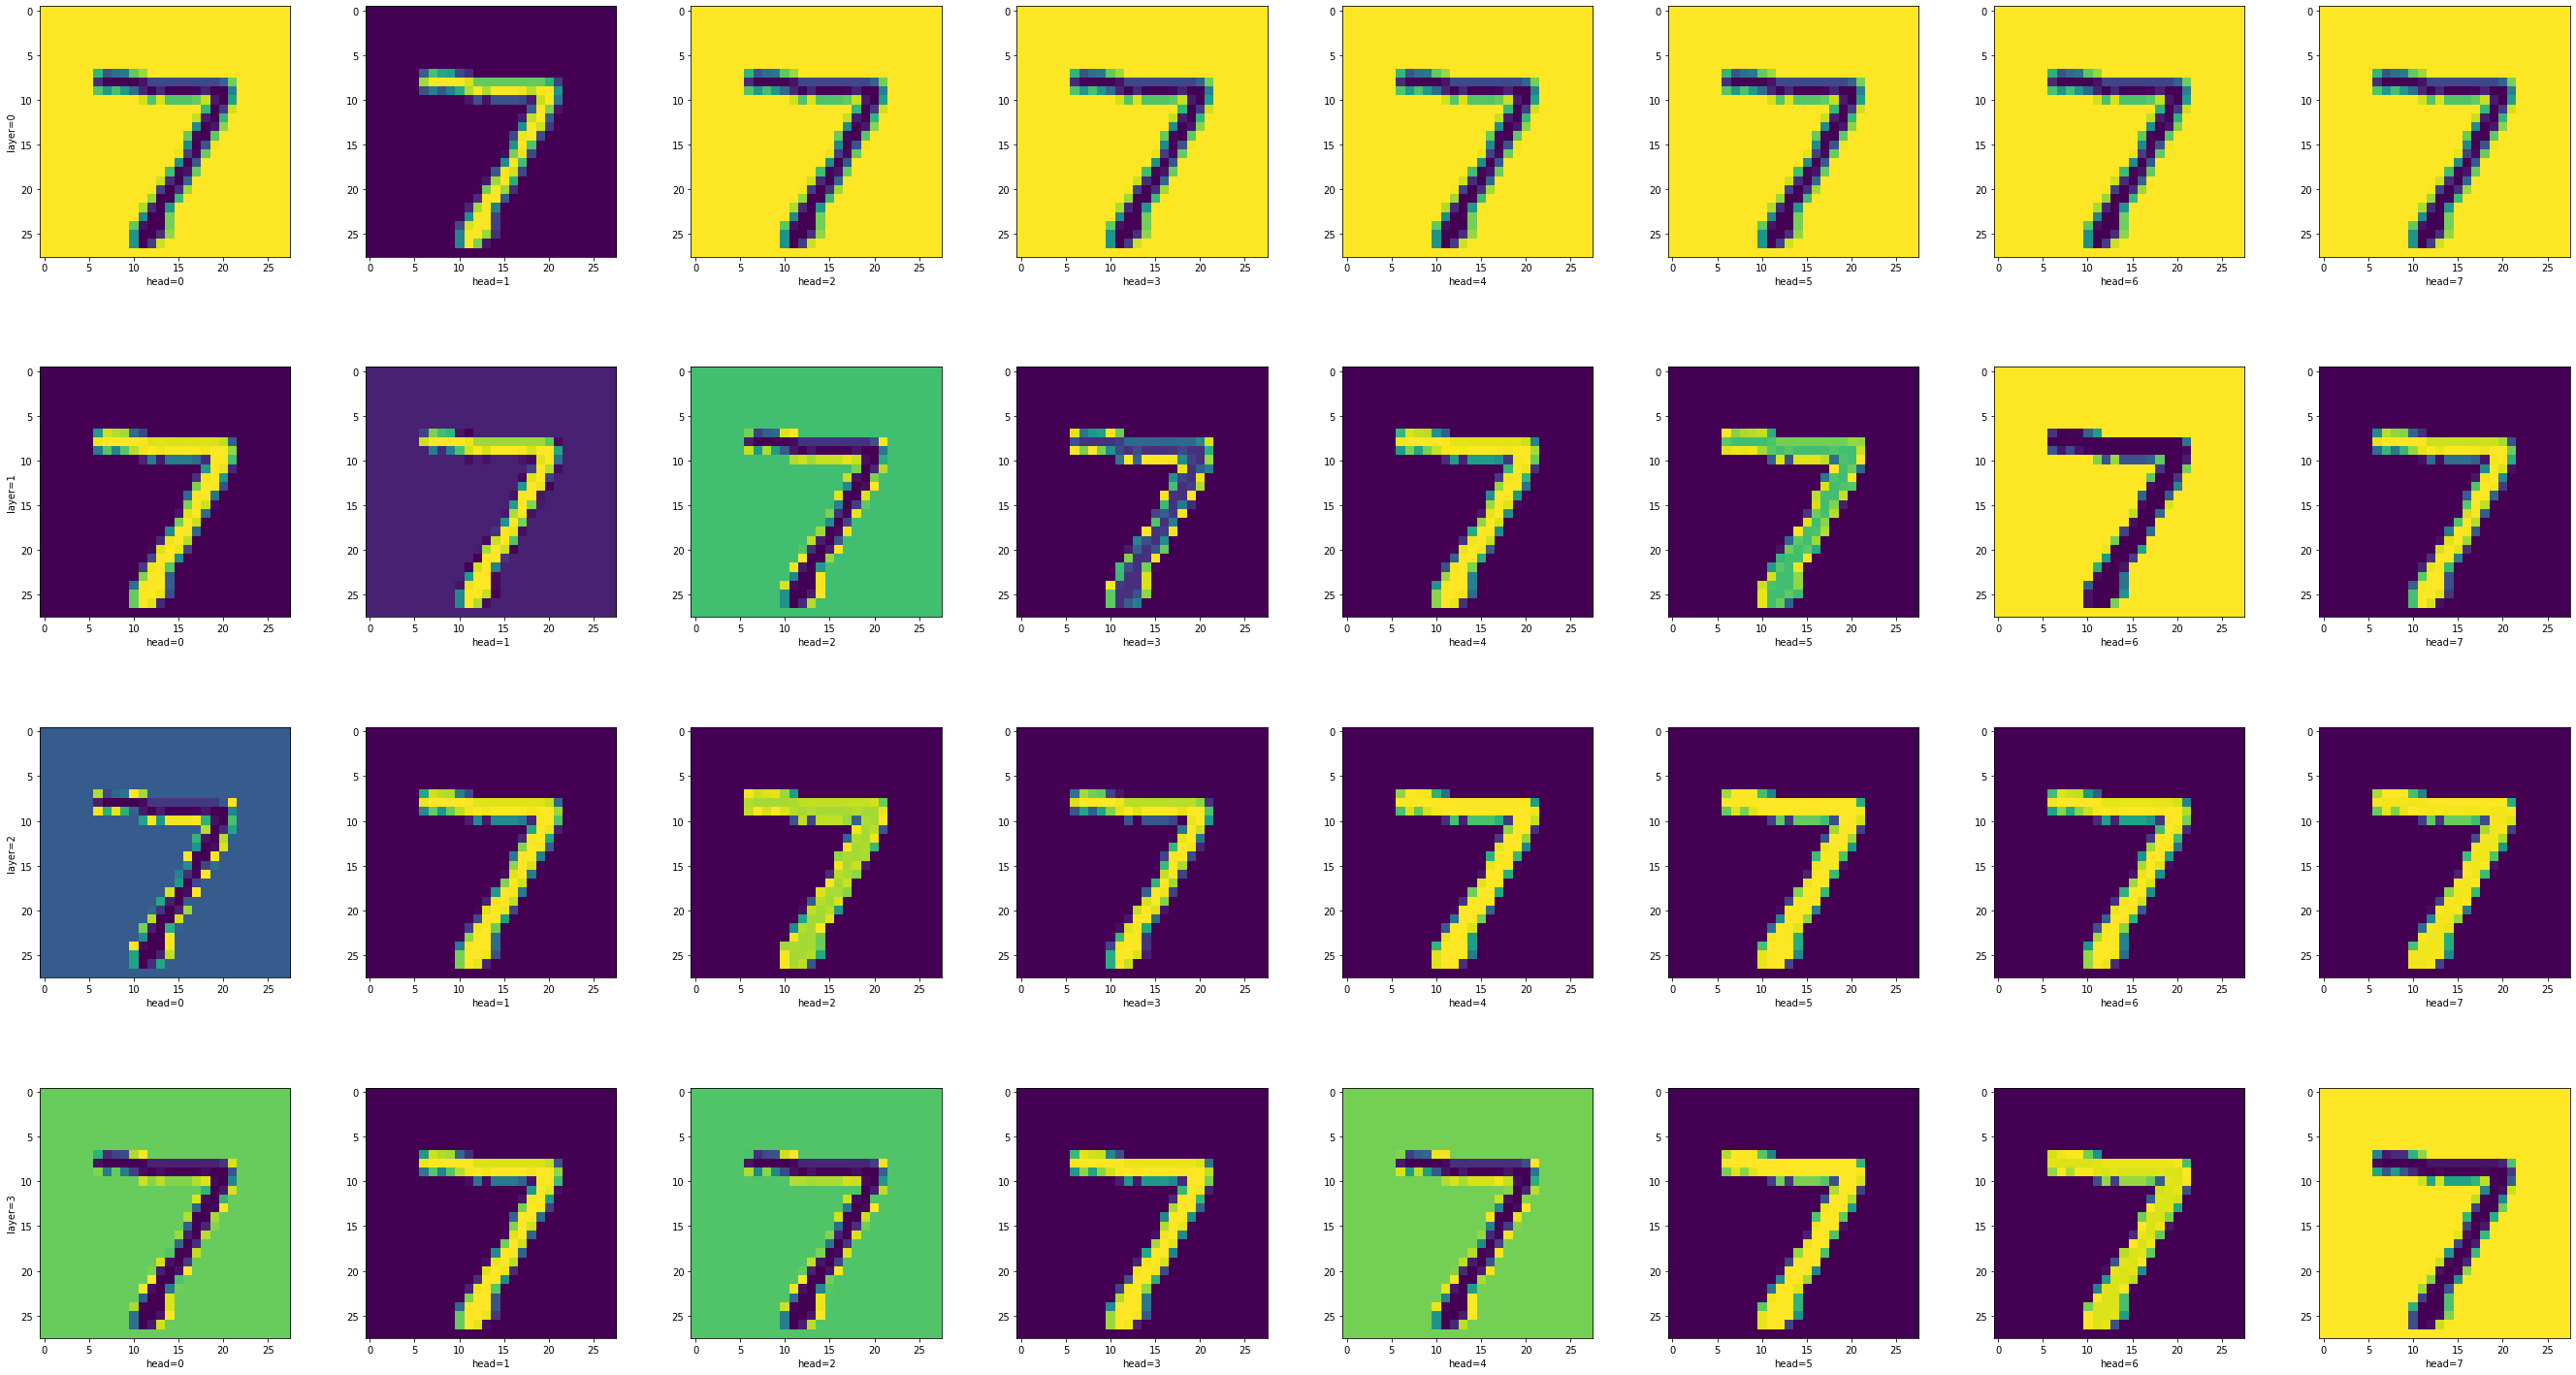

Transformers Decoder Self-Attention


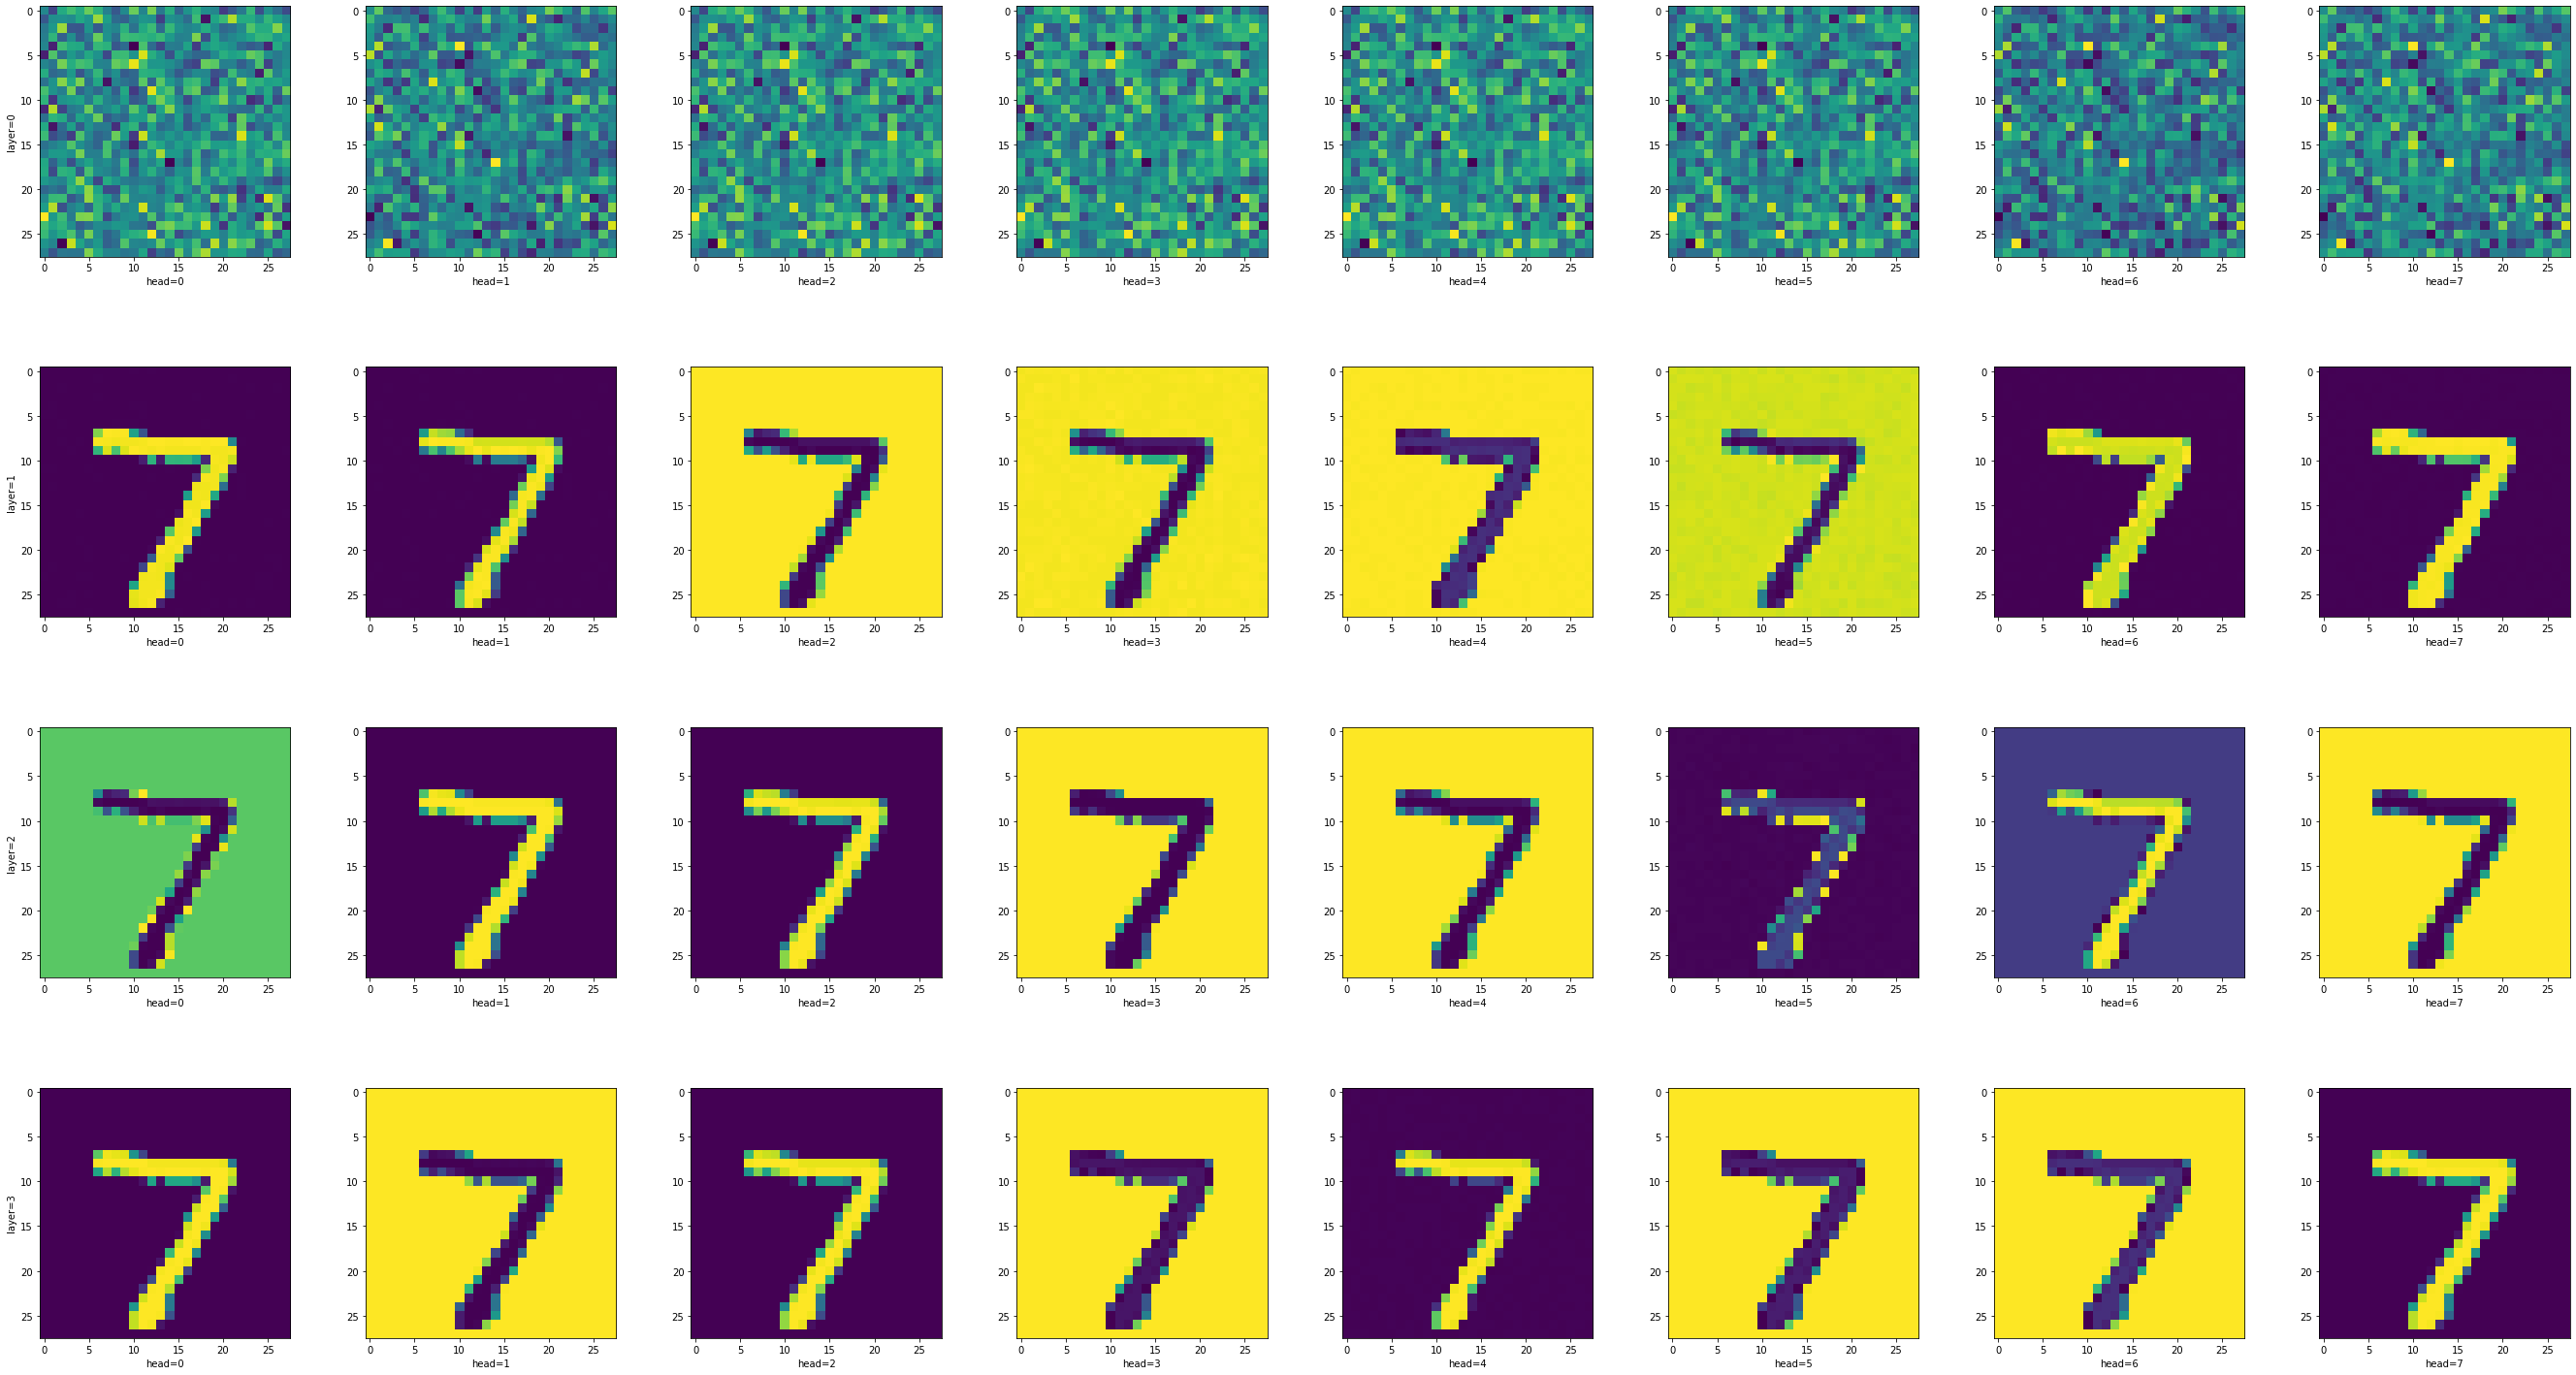

Transformers Decoder Cross-Attention


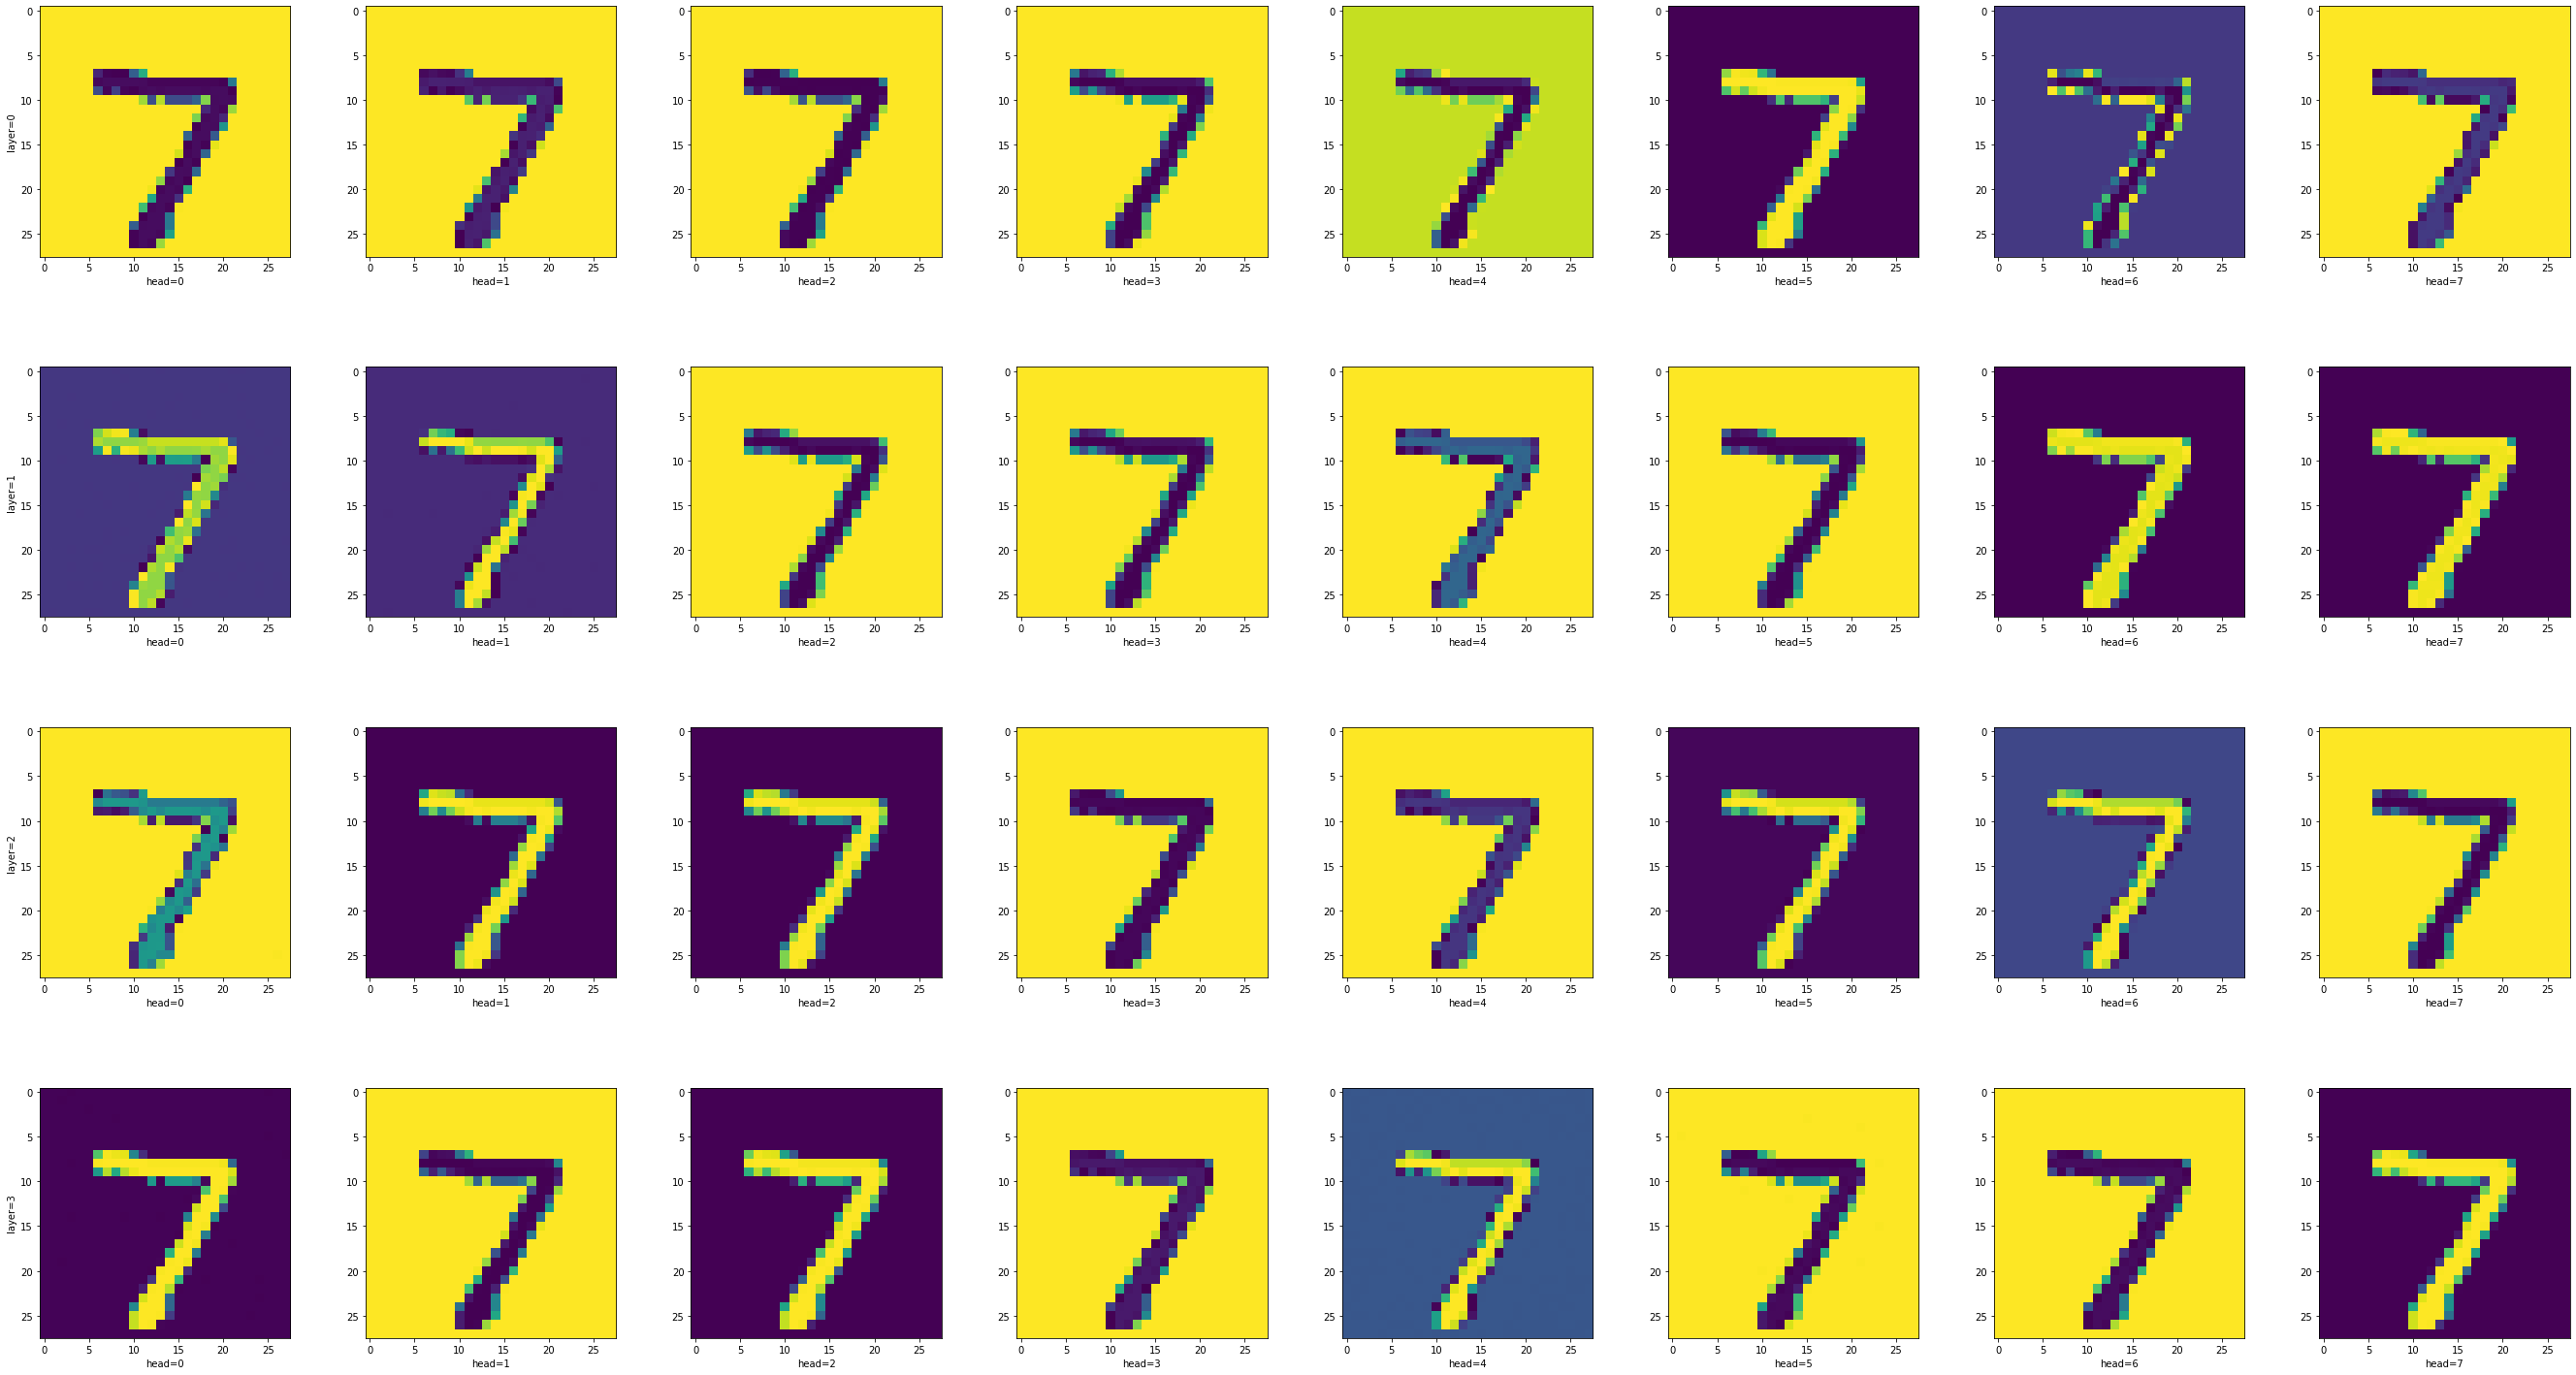

Learnt Query Vectors


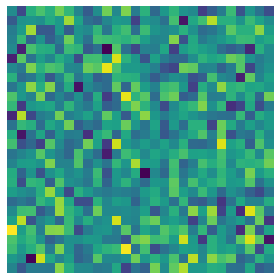

In [13]:
visualize_model_layers(model, testloader)

## Train and visualize encoder-only model

In [12]:
config = Config(device=device, 
                hidden_size=128, 
                n_heads=8, 
                n_encoders=4, 
                encoder_only=True)
model = Transformers(config).to(device)
model = train(model)

epoch [1], step [ 3000] loss: 1.64519807 acc: 0.82250001
epoch [2], step [ 3000] loss: 1.64287849 acc: 0.82150001
Training took 743.0778863430023 seconds.
Performing validation


  0%|          | 0/500 [00:00<?, ?it/s]

Validation accuracy: 0.8331000137329102


Prediction: 7, True: 7


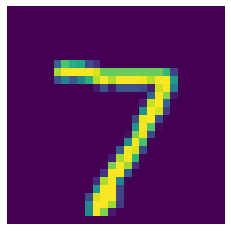

Transformers Encoder Self-Attention


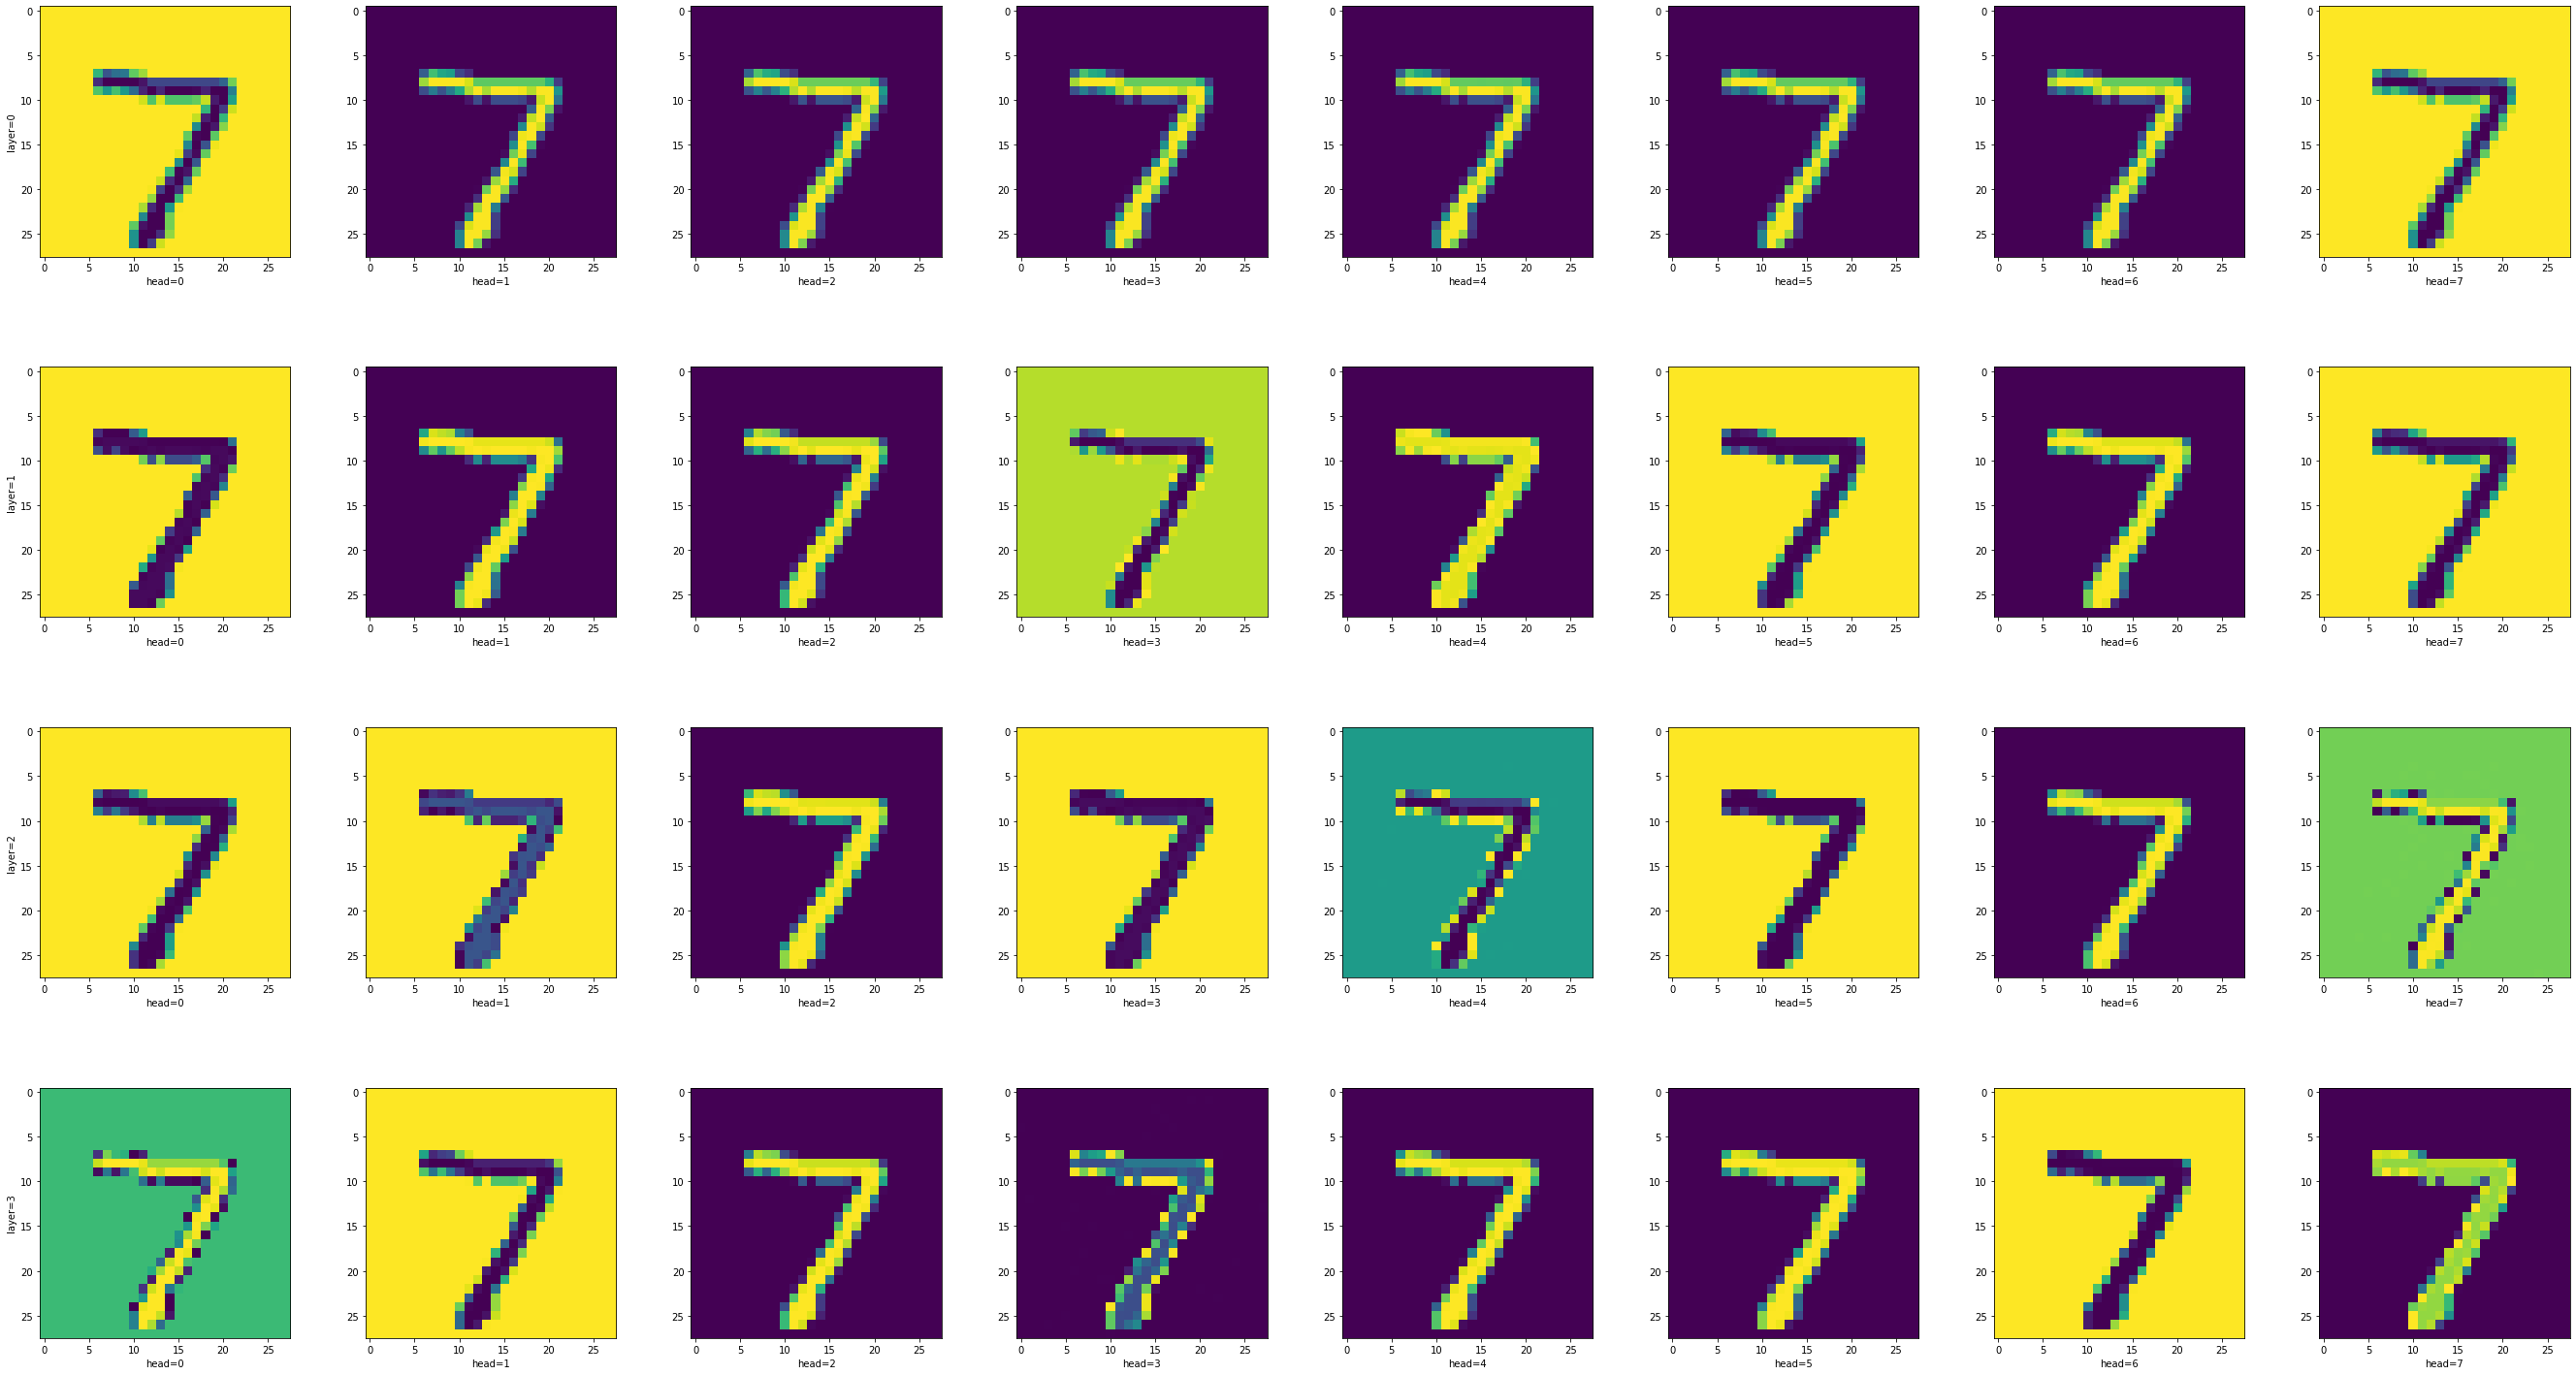

In [13]:
visualize_model_layers(model, testloader)

We almost achieve same level of validation accuracy with and without the additional decoder. For both encoder and decoder, we use a learnable positional embedding here. A common choice for that in NLP is to use a combination of sine and cosine functions which can easily generalize to a different length sequence at run-time. Since the sequence length is fixed in the case of images, learnable vectors work great.

All the attention weights visualized here is shown for the center pixel of the image, meaning how much the center pixel pays attention to every other pixels in the image. Rows of the plots show attention weights for each encoder/decoder (4 encoder/decoder used in this example), and the columns correspond to each head of the Multi-Headed Attention (8 used in this example).

I hope this was helpful. Go ahead and try this yourself, feel free to clone the GitHub repository and give it a spin. Happy Learning!

[GitHub Repository](https://github.com/towardsautonomy/transformers)